<a href="https://colab.research.google.com/github/ViNguyen94/movie-time-series/blob/master/movie_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!pip install tensorflow==2.0.0-beta1

In [0]:
!ls -al

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
!pip install --quiet --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# Import library

In [0]:

# Pandas
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series
# numpy
import numpy as np
from numpy import concatenate
from numpy import vstack, hstack

# datetime
from datetime import datetime
import time, datetime

# plot
import matplotlib.pyplot as plt

# Skitlearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

#LSTM libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout

# math
from math import sqrt
import math

# random data
from random import sample 
import random

# tensorflow 2 
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
# uszipcode
#from uszipcode import SearchEngine, SimpleZipcode, Zipcode

import tqdm
import os

# Load dataset

## Load rating dataset

In [22]:
rating_df = pd.read_csv('/content/drive/My Drive/My Colab/FL_newdata_1M/ratings.dat',
           sep='::', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

# Convert timestamp to standard day form
rating_df['datetime'] = pd.to_datetime(rating_df['timestamp'], unit='s')

# Convert in day
rating_df['time'] = rating_df['datetime'].dt.strftime('%Y-%m-%d')  

# Drop timestamp and rating column
rating_df = rating_df.drop(['rating', 'timestamp','datetime'], axis=1)  
 
print('RATINGS DATASET: \n', rating_df)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


RATINGS DATASET: 
          userId  movieId        time
0             1     1193  2000-12-31
1             1      661  2000-12-31
2             1      914  2000-12-31
3             1     3408  2000-12-31
4             1     2355  2001-01-06
...         ...      ...         ...
1000204    6040     1091  2000-04-26
1000205    6040     1094  2000-04-25
1000206    6040      562  2000-04-25
1000207    6040     1096  2000-04-26
1000208    6040     1097  2000-04-26

[1000209 rows x 3 columns]


## Load user dataset

Age is chosen from the following ranges:

    * 1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"







In [24]:
user_df = pd.read_csv('/content/drive/My Drive/My Colab/FL_newdata_1M/users.dat',
            sep='::', header=None, names=['userId', 'gender', 'age', 'occupation', 'zipcode'])
print('USERS DATASET: \n', user_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


USERS DATASET: 
       userId gender  age  occupation zipcode
0          1      F    1          10   48067
1          2      M   56          16   70072
2          3      M   25          15   55117
3          4      M   45           7   02460
4          5      M   25          20   55455
...      ...    ...  ...         ...     ...
6035    6036      F   25          15   32603
6036    6037      F   45           1   76006
6037    6038      F   56           1   14706
6038    6039      F   45           0   01060
6039    6040      M   25           6   11106

[6040 rows x 5 columns]


## Load movie dataset

In [26]:
movie_df = pd.read_csv('/content/drive/My Drive/My Colab/FL_newdata_1M/movies.dat',
            sep='::', header=None, names=['movieId', 'title', 'genre'])
print('MOVIE DATASET: \n', movie_df)


MOVIE DATASET: 
       movieId                               title                         genre
0           1                    Toy Story (1995)   Animation|Children's|Comedy
1           2                      Jumanji (1995)  Adventure|Children's|Fantasy
2           3             Grumpier Old Men (1995)                Comedy|Romance
3           4            Waiting to Exhale (1995)                  Comedy|Drama
4           5  Father of the Bride Part II (1995)                        Comedy
...       ...                                 ...                           ...
3878     3948             Meet the Parents (2000)                        Comedy
3879     3949          Requiem for a Dream (2000)                         Drama
3880     3950                    Tigerland (2000)                         Drama
3881     3951             Two Family House (2000)                         Drama
3882     3952               Contender, The (2000)                Drama|Thriller

[3883 rows x 3 columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# Dataframe associated with group of users having same age

In [0]:
# Function to generate dataframe associated with age group
def create_age_group(age_group, user_df, rating_df):

    # pick users with the same age
    group_userId = user_df[user_df['age'] == age_group].reset_index(drop=True) # use 'isin' to select rows whose values in an given array  
    group_userId = group_userId['userId']
    group_userId = np.asarray(group_userId)
    
    # extract information of this group from rating dataframe
    group_age_df = rating_df[rating_df['userId'].isin(group_userId)].reset_index(drop=True)
    
    group_age_df = group_age_df.sort_values(by='time')
    group_age_df = group_age_df.reindex(columns=['time','movieId', 'userId']).reset_index(drop=True)
    
    return group_age_df


In [31]:
# Take group of users from 25 to 34 years old, which is encoded as 25
age_group = 25 

# Generate dataframe associated with the age group
group_age_df = create_age_group(age_group, user_df, rating_df)

print ('DATA FRAME ASSOCIATED WITH GROUP AGE 25: \n', group_age_df )

DATA FRAME ASSOCIATED WITH GROUP AGE 25: 
               time  movieId  userId
0       2000-04-25      246    6040
1       2000-04-25      649    6040
2       2000-04-25      919    6040
3       2000-04-25     1649    6040
4       2000-04-25     2384    6040
...            ...      ...     ...
395551  2003-02-27     3196    5950
395552  2003-02-27     1997    5950
395553  2003-02-27     3328    5950
395554  2003-02-28     3267    5312
395555  2003-02-28     2648    3158

[395556 rows x 3 columns]


In [33]:
# Count the number of users and number of movies in the group
n_user = len(group_age_df['userId'].unique()) # no. users
print ('Number of users: ', n_user)

n_movie = len(group_age_df['movieId'].unique()) # no. movies
print ('Number of movies: ', n_movie)

total_view = len(group_age_df['movieId']) # total views
print ('Total views: ', total_view)

n_day = len(group_age_df['time'].unique()) # total days
print ('Total days: ', n_day)

average_view_per_day = total_view/n_day # average view per day
print ('Average view per day: ', average_view_per_day)

Number of users:  2096
Number of movies:  3508
Total views:  395556
Total days:  1026
Average view per day:  385.53216374269005


# Generate movie series for each movie 

In [0]:
# Set a period of time 
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2003, 2, 28)
range_of_time = pd.date_range(start, end) 

In [0]:
# Function to generate movie series
def generate_movie_series(movie_list, movie_list_df, range_of_time):
    
    movie_series = pd.DataFrame()
    for i in range(len(movie_list)): 
        idx = movie_list[i]
        temp = movie_list_df[movie_list_df['movieId']==idx].reset_index(drop=True)
        
        temp = temp.groupby(['time']).size().reset_index()
    
        temp = temp.rename({0 : 'movie %i' %idx}, axis=1) 
        
        # fill in missing date
        count = temp['movie %i' %idx] # extract 'count' colum and 'time' column
        time_slot = pd.to_datetime(temp['time']) # Convert the data frame index to a datetime index
       
        temp = pd.DataFrame({'time': time_slot, 'movie %i' %idx : count})
        temp = temp.set_index('time').reindex(range_of_time).fillna(0).astype(int).rename_axis('time')
        movie_series = pd.concat([movie_series, temp], axis=1)    
    return movie_series


## Extract a list of movies with highest views 

In [0]:
# Take 100 movies with highest views that this group watched
most_view_movies = group_age_df.groupby('movieId').size().sort_values(ascending=False)[:100]
most_view_movies = pd.DataFrame(most_view_movies).reset_index()
most_view_movies = most_view_movies['movieId'].values

## Generate time series for each movie in the list

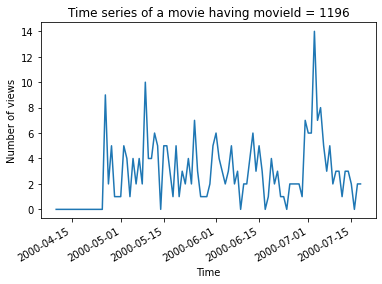

In [45]:
# generate time series for each movie
movies_series = generate_movie_series(most_view_movies, group_age_df, range_of_time)

# plot one time serie of a specific movie for instance 
plt.figure()
plt.plot(movies_series.iloc[100:200,1])
plt.gcf().autofmt_xdate()
plt.title('Time series of a movie having movieId = %i' % most_view_movies[1])
plt.xlabel('Time')
plt.ylabel('Number of views')
plt.show()

